In [1]:
%autoreload 2


In [2]:
from argparse import Namespace
from collections import defaultdict
import copy
import difflib
import gzip
import itertools
import os
import pickle
import sys
import typing

from IPython.display import display, Markdown, HTML
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.pipeline import Pipeline
import tatsu
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tqdm.notebook as tqdm


sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src'))
from src import fitness_energy_utils as utils
from src.fitness_energy_utils import NON_FEATURE_COLUMNS
from src.ast_counter_sampler import *
from src.ast_utils import cached_load_and_parse_games_from_file, load_games_from_file, _extract_game_id
from src import ast_printer

2023-05-08 11:00:30 - ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache
2023-05-08 11:00:30 - src.ast_utils - DEBUG    - Using cache folder: /var/folders/h9/kzpqpksx6fq00v9d73x5j51c0000gn/T/game_generation_cache


In [3]:
grammar = open('../dsl/dsl.ebnf').read()
grammar_parser = tatsu.compile(grammar)
game_asts = list(cached_load_and_parse_games_from_file('../dsl/interactive-beta.pddl', grammar_parser, False, relative_path='..'))
real_game_texts = [ast_printer.ast_to_string(ast, '\n') for ast in game_asts]
regrown_game_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples.pddl'))
regrown_game_1024_texts = list(load_games_from_file('../dsl/ast-real-regrowth-samples-1024.pddl'))
print(len(real_game_texts), len(regrown_game_texts), len(regrown_game_texts) / 98, len(regrown_game_1024_texts), len(regrown_game_1024_texts) / 98)


98 6272 64.0 100352 1024.0


In [4]:
def extract_game_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    index = game_name[first_dash + 1:second_dash] if second_dash != -1 else game_name[first_dash + 1:]
    return int(index)


def extract_negative_index(game_name: str):
    first_dash = game_name.find('-')
    second_dash = game_name.find('-', first_dash + 1)
    if second_dash == -1:
        return -1
    
    third_dash = game_name.find('-', second_dash + 1)
    index = game_name[second_dash + 1:third_dash]
    return int(index)


fitness_df = utils.load_fitness_data('../data/fitness_features_1024_regrowths.csv.gz')

# fitness_df = fitness_df.assign(real=fitness_df.real.astype('int'), game_index=fitness_df.game_name.apply(extract_game_index), 
#                                negative_index= fitness_df.game_name.apply(extract_negative_index), fake=~fitness_df.real.astype('int'))
# fitness_df = fitness_df.sort_values(by=['fake', 'game_index', 'negative_index'], ignore_index=True).reset_index(drop=True)
# fitness_df.drop(columns=['Index', 'fake', 'game_index', 'negative_index'], inplace=True)
print(fitness_df.src_file.unique())
fitness_df.head()

['interactive-beta.pddl' 'ast-real-regrowth-samples-1024.pddl']


,Index,src_file,game_name,domain_name,original_game_name,real,all_variables_defined,all_variables_used,all_preferences_used,num_preferences_defined_1,...,ast_ngram_constraints_n_6_score,ast_ngram_constraints_n_7_score,ast_ngram_terminal_n_2_score,ast_ngram_terminal_n_3_score,ast_ngram_terminal_n_4_score,ast_ngram_terminal_n_5_score,ast_ngram_scoring_n_2_score,ast_ngram_scoring_n_3_score,ast_ngram_scoring_n_4_score,ast_ngram_scoring_n_5_score
0,0,interactive-beta.pddl,6172feb1665491d1efbce164-0,medium-objects-room-v1,6172feb1665491d1efbce164-0,1,1,1,1,0,...,0.975856,0.984382,0.970248,0.981414,0.981920,0.983617,0.919078,0.915602,0.974574,0.987096
1,1,interactive-beta.pddl,5f77754ba932fb2c4ba181d8-2,many-objects-room-v1,5f77754ba932fb2c4ba181d8-2,1,1,1,1,0,...,0.985632,0.986181,0.966645,0.978594,0.977472,0.984273,0.921563,0.931860,0.945369,0.962067
2,2,interactive-beta.pddl,614b603d4da88384282967a7-3,many-objects-room-v1,614b603d4da88384282967a7-3,1,1,1,1,1,...,0.975984,0.980604,0.000000,0.000000,0.000000,0.000000,0.844787,0.858832,0.923039,0.942307
3,3,interactive-beta.pddl,5bc79f652885710001a0e82a-5,few-objects-room-v1,5bc79f652885710001a0e82a-5,1,1,1,1,1,...,0.986042,0.985931,0.000000,0.000000,0.000000,0.000000,0.919078,0.915602,0.974574,0.987096
4,4,interactive-beta.pddl,614dec67f6eb129c3a77defd-6,medium-objects-room-v1,614dec67f6eb129c3a77defd-6,1,1,1,1,0,...,0.984624,0.983172,0.000000,0.000000,0.000000,0.000000,0.976741,0.978090,0.970715,0.987147


In [5]:
# USE_BINARIZED_FEATURES_MODEL = True

# if USE_BINARIZED_FEATURES_MODEL:
#     model_path = '../models/cv_binarized_model_2023_01_20.pkl.gz'
#     data_df = binarized_df
# else:
#     model_path = '../models/cv_fitness_model_2023_01_20.pkl.gz'
#     data_df = filtered_fitness_df
from latest_model_paths import LATEST_FITNESS_FUNCTION_DATE_ID
model_date_id = LATEST_FITNESS_FUNCTION_DATE_ID
data_df = fitness_df
cv_energy_model, feature_columns = utils.load_model_and_feature_columns(model_date_id)
print(len(feature_columns))



345


In [6]:
from collections import Counter
counter = Counter([c[:c.index('arg_types') - 1] for c in data_df.columns if 'arg_types' in c])
print(', '.join(f'{k}: {v}' for k, v in counter.items()))

adjacent: 19, adjacent_side_3: 4, agent_holds: 11, between: 2, distance: 26, in: 17, in_motion: 11, object_orientation: 6, on: 34, touch: 16


In [7]:
data_df[data_df.real == 1][[c for c in data_df.columns if 'compositionality' in c]].sum()

compositionality_structure_0    66
compositionality_structure_1    54
compositionality_structure_2    36
compositionality_structure_3    31
compositionality_structure_4    18
compositionality_structure_5    13
compositionality_structure_6    10
compositionality_structure_7     7
compositionality_structure_8     4
compositionality_structure_9     3
dtype: int64

## Histogram the weights to get a sense of what we're dealing with

2023-05-08 11:00:39 - matplotlib.pyplot - DEBUG    - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-08 11:00:39 - matplotlib.pyplot - DEBUG    - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXNonUni.ttf', name='STIXNonUnicode', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/Users/guydavidson/opt/anaconda3/envs/game-gen/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant=

Weights mean: 0.1168, std: 2.2325, bias: 0.0100


2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/Sinhala MN.ttc', name='Sinhala MN', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansGunjalaGondi-Regular.otf', name='Noto Sans Gunjala Gondi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/NotoSansCypriot-Regular.ttf', name='Noto Sans Cypriot', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2023-05-08 11:00:39 - matplotlib.font_manager - DEBUG    - findfont: score(FontEntry(fname='/System/Library/Fonts/Supplemental/PTSerifCaption.ttc', name='PT Serif Caption', style='normal', v

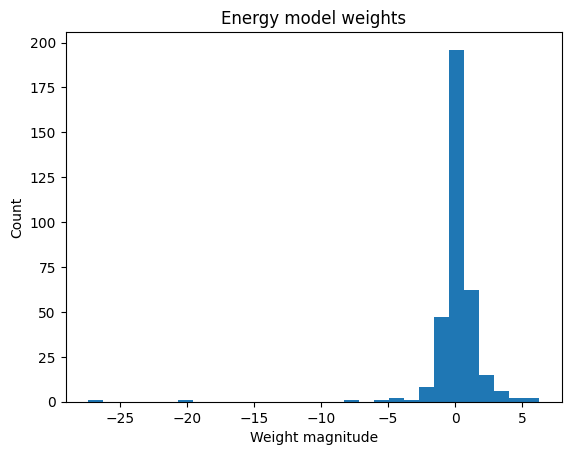

In [8]:
weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
bias = cv_energy_model.named_steps['fitness'].model.fc1.bias.data.detach().squeeze()  # type: ignore
print(f'Weights mean: {weights.mean():.4f}, std: {weights.std():.4f}, bias: {bias:.4f}')

plt.hist(weights, bins=30)
plt.title('Energy model weights')
plt.xlabel('Weight magnitude')
plt.ylabel('Count')
plt.show()

In [9]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
quantile_index = 0

abs_weights = weights.abs()

for magnitude in torch.linspace(0,abs_weights.max(), 5000):
    n = torch.sum(abs_weights < magnitude).item()
    if n / len(weights) >= quantiles[quantile_index]:
        print(f'Approximately {quantiles[quantile_index] * 100}% ({n}, {n / len(weights) * 100:.2f}%) of the weights have magnitude < {magnitude:.4f}')
        quantile_index += 1

    if quantile_index >= len(quantiles):
        break

Approximately 10.0% (35, 10.14%) of the weights have magnitude < 0.0657
Approximately 25.0% (90, 26.09%) of the weights have magnitude < 0.2026
Approximately 50.0% (175, 50.72%) of the weights have magnitude < 0.4929
Approximately 75.0% (260, 75.36%) of the weights have magnitude < 0.9748
Approximately 90.0% (311, 90.14%) of the weights have magnitude < 1.9497
Approximately 95.0% (328, 95.07%) of the weights have magnitude < 2.7548
Approximately 99.0% (342, 99.13%) of the weights have magnitude < 6.2653


## Print the top K features most and least predictive of real games

In [10]:
K = 20
top_features = torch.topk(weights, K)
bottom_features = torch.topk(weights, K, largest=False)

lines = []

lines.append('### Features with largest negative weights (most predictive of real games):')
for i in range(K):
    lines.append(f'{i+1}. {feature_columns[bottom_features.indices[i]]} ({bottom_features.values[i]:.4f})')

lines.append('### Features with largest positive weights (most predictive of fake games):')
for i in range(K):
    lines.append((f'{i+1}. {feature_columns[top_features.indices[i]]} ({top_features.values[i]:.4f})'))

display(Markdown('\n'.join(lines)))


### Features with largest negative weights (most predictive of real games):
1. ast_ngram_full_n_7_score (-27.3778)
2. ast_ngram_constraints_n_7_score (-19.9004)
3. ast_ngram_setup_n_5_score (-8.2723)
4. all_variables_used (-5.0115)
5. all_preferences_used (-4.4579)
6. ast_ngram_scoring_n_5_score (-3.8760)
7. ast_ngram_terminal_n_5_score (-2.9615)
8. in_motion_arg_types_small_objects_constraints (-2.5247)
9. all_variables_defined (-2.0570)
10. section_doesnt_exist_setup (-2.0319)
11. on_arg_types_furniture_large_objects_constraints (-1.9611)
12. node_count_setup_0 (-1.9001)
13. max_depth_setup_0 (-1.8022)
14. mean_depth_setup_0 (-1.7993)
15. pref_forall_pref_forall_correct_arity_correct (-1.6215)
16. setup_quantified_objects_used (-1.5835)
17. distance_arg_types_balls_balls_setup (-1.5826)
18. setup_objects_used (-1.5401)
19. in_arg_types_receptacles_any_object_constraints (-1.3713)
20. num_preferences_defined_1 (-1.3244)
### Features with largest positive weights (most predictive of fake games):
1. pref_forall_pref_forall_correct_types_incorrect (6.2629)
2. pref_forall_used_incorrect (6.0707)
3. repeated_variables_found (4.8894)
4. two_number_operation_found (4.1976)
5. disjoint_seq_funcs_found (3.9196)
6. in_arg_types_other_constraints (3.6889)
7. adjacent_arg_types_other_constraints (3.5328)
8. redundant_expression_found (3.3068)
9. distance_arg_types_other_constraints (3.3048)
10. pref_forall_pref_forall_correct_arity_incorrect (3.2250)
11. in_motion_arg_types_other_setup (2.7524)
12. in_motion_arg_types_room_features_constraints (2.7111)
13. agent_holds_arg_types_other_setup (2.6556)
14. distance_arg_types_furniture_receptacles_setup (2.6161)
15. in_motion_arg_types_agent_constraints (2.5543)
16. agent_holds_arg_types_room_features_constraints (2.5174)
17. adjacent_arg_types_room_features_room_features_constraints (2.4844)
18. nested_logicals_found (2.3452)
19. agent_holds_arg_types_agent_constraints (2.3361)
20. in_motion_arg_types_other_constraints (2.2872)

In [11]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'logical' in c]

[('nested_logicals_found', tensor(2.3452)),
 ('identical_logical_children_found', tensor(1.1517)),
 ('tautological_expression_found', tensor(1.0770))]

In [12]:
[(c, weights[i]) for i, c in enumerate(feature_columns) if 'pref' in c]

[('all_preferences_used', tensor(-4.4579)),
 ('num_preferences_defined_1', tensor(-1.3244)),
 ('num_preferences_defined_2', tensor(0.5340)),
 ('num_preferences_defined_3', tensor(-0.8042)),
 ('num_preferences_defined_4', tensor(0.0307)),
 ('num_preferences_defined_5', tensor(0.6667)),
 ('num_preferences_defined_6', tensor(0.8478)),
 ('pref_forall_count_once_per_external_objects_used_correct', tensor(0.7776)),
 ('pref_forall_count_once_per_external_objects_used_incorrect',
  tensor(0.0380)),
 ('pref_forall_external_forall_used_correct', tensor(0.5022)),
 ('pref_forall_external_forall_used_incorrect', tensor(0.4496)),
 ('pref_forall_used_correct', tensor(1.5296)),
 ('pref_forall_used_incorrect', tensor(6.0707)),
 ('pref_forall_pref_forall_correct_arity_correct', tensor(-1.6215)),
 ('pref_forall_pref_forall_correct_arity_incorrect', tensor(3.2250)),
 ('pref_forall_pref_forall_correct_types_correct', tensor(0.9315)),
 ('pref_forall_pref_forall_correct_types_incorrect', tensor(6.2629)),
 ('

In [13]:
data_df.groupby('real').distance_arg_types_furniture_receptacles_setup.describe()

,count,mean,std,min,25%,50%,75%,max
real,,,,,,,,
0,100352.0,0.011779,0.107888,0.0,0.0,0.0,0.0,1.0
1,98.0,0.010204,0.101015,0.0,0.0,0.0,0.0,1.0


In [14]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if 'disjoint_seq_funcs_found' in c]

[('disjoint_seq_funcs_found', tensor(3.9196))]

In [15]:
[(c, weights[feature_columns.index(c)]) for c in feature_columns if c.startswith('ast_ngram') and c.endswith('score')]

[('ast_ngram_full_n_7_score', tensor(-27.3778)),
 ('ast_ngram_setup_n_5_score', tensor(-8.2723)),
 ('ast_ngram_constraints_n_7_score', tensor(-19.9004)),
 ('ast_ngram_terminal_n_5_score', tensor(-2.9615)),
 ('ast_ngram_scoring_n_5_score', tensor(-3.8760))]

In [16]:
threshold = 5.0

fs = [c for i, c in enumerate(feature_columns) if 
      (weights[i].abs() < threshold) and ('arg_types' in c  or c.startswith('compositionality') or c.startswith('predicate_under_'))]

len(fs)

206

In [17]:
p = 0.1
s = data_df[data_df.real == 1][fs].mean().sort_values(ascending=False)
print(len(s[s > p]))
s[s > p].index

31


Index(['predicate_under_modal_once_agent_holds',
       'predicate_under_modal_once_in_motion',
       'predicate_under_modal_hold_agent_holds',
       'predicate_under_modal_hold_in_motion',
       'agent_holds_arg_types_balls_constraints',
       'in_motion_arg_types_balls_constraints', 'compositionality_structure_0',
       'predicate_under_modal_once_in',
       'in_arg_types_receptacles_balls_constraints',
       'compositionality_structure_1', 'compositionality_structure_2',
       'predicate_under_modal_once_on', 'compositionality_structure_3',
       'predicate_under_modal_while_hold_in_motion',
       'predicate_under_modal_while_hold_agent_holds',
       'predicate_under_modal_once_adjacent',
       'predicate_under_modal_while_hold_touch',
       'in_motion_arg_types_blocks_constraints',
       'compositionality_structure_4',
       'agent_holds_arg_types_blocks_constraints',
       'on_arg_types_room_features_agent_constraints',
       'compositionality_structure_5', 'predi

## Plot a histogram of the values for each of the and bottom K features

In [18]:
def plot_value_histograms(df: pd.DataFrame, weights: torch.Tensor, k: int = 10,
    largest: bool = True, bins: int = 100, histogram_log_y: bool = True, 
    histogram_density: bool = True, layout: typing.Optional[typing.Tuple[int, int]] = None,
    figsize: typing.Optional[typing.Tuple[float, float]] = None, 
    panel_width: float = 4, panel_height: float = 4, ylabel_once_per_row: bool = True,
    subplots_adjust_params: typing.Optional[typing.Dict[str, float]] = None,
    title_fontsize: int = 12, title_split_threshold: int = 25,
    cm: plt.get_cmap('tab20') = plt.get_cmap('tab20')):  # type: ignore
    
    if layout is None:
        largest_div = int(np.floor(k ** 0.5))
        while k % largest_div != 0:
            largest_div -= 1

        layout = (largest_div, k // largest_div)

    if figsize is None:
        figsize = (layout[1] * panel_width, layout[0] * panel_height)

    fig, axes = plt.subplots(*layout, figsize=figsize)

    top_k = torch.topk(weights, k, largest=largest)

    for i in range(k):
        feature_index = top_k.indices[i]
        ax = axes[i // layout[1]][i % layout[1]]

        real_values = df[df.real == 1][feature_columns[feature_index]].to_numpy()
        synthetic_values = df[df.real == 0][feature_columns[feature_index]].to_numpy()

        # print(f'Feature = 0 {(real_values == 0).mean() * 100:.2f}% of the time in real games, {(synthetic_values == 0).mean() * 100:.2f}% of the time in synthetic games')

        ax.hist([real_values, synthetic_values], label=['Real games', 'Regrown games'], 
            stacked=False, density=histogram_density, bins=bins, color=[cm.colors[0], cm.colors[2]])  # type: ignore
        ax.set_xlabel('Feature value')

        if not ylabel_once_per_row or i % layout[1] == 0:
            if histogram_density:
                if histogram_log_y:
                    ax.set_ylabel('log(Density)')
                else:
                    ax.set_ylabel('Density')
            elif histogram_log_y:
                ax.set_ylabel('log(Count)')
            else:
                ax.set_ylabel('Count')

        if histogram_log_y:
            ax.semilogy()
        
        title_feature = f'#{i + 1}: {feature_columns[feature_index]}'
        title_weight = f'(weight: {top_k.values[i]:.4f})'
        if len(title_feature) > title_split_threshold:
            title_split_index = title_feature.find('_', title_split_threshold) + 1
            if title_split_index == 0:
                title_split_index = len(title_feature)
            title = f'{title_feature[:title_split_index]}\n{title_feature[title_split_index:]} {title_weight}'
        else:
            title = f'{title_feature}\n{title_weight}'

        ax.set_title(title, fontdict=dict(fontsize=title_fontsize))
        ax.legend(loc='best')

    if subplots_adjust_params is not None:
        plt.subplots_adjust(**subplots_adjust_params)
        
    plt.show()

        

## For the 20 features with the largest negative weights, that is, most predictive of real games

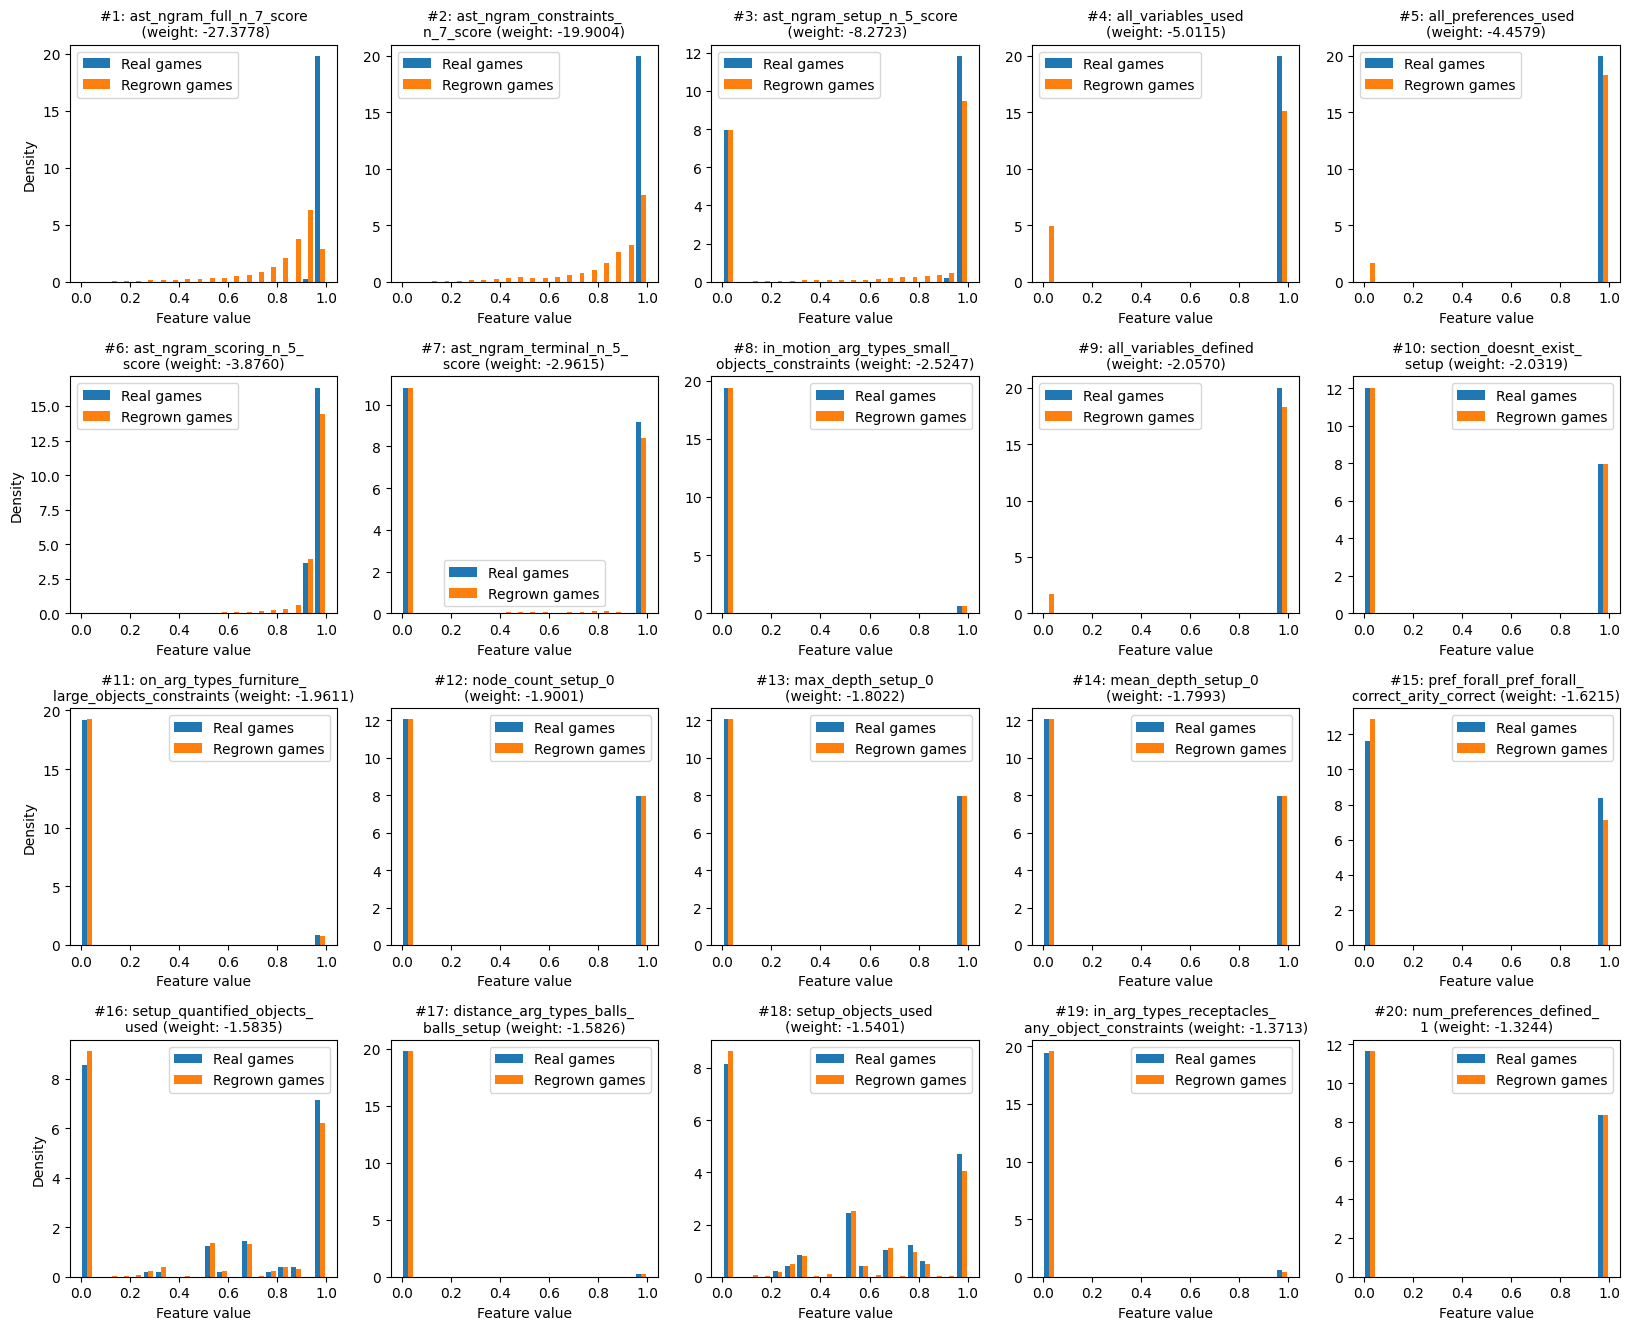

In [19]:
k = 20
plot_value_histograms(data_df, weights, k=k, largest=False, bins=20, histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## For the 20 features with largest weights, that is, most predictive of a fake game

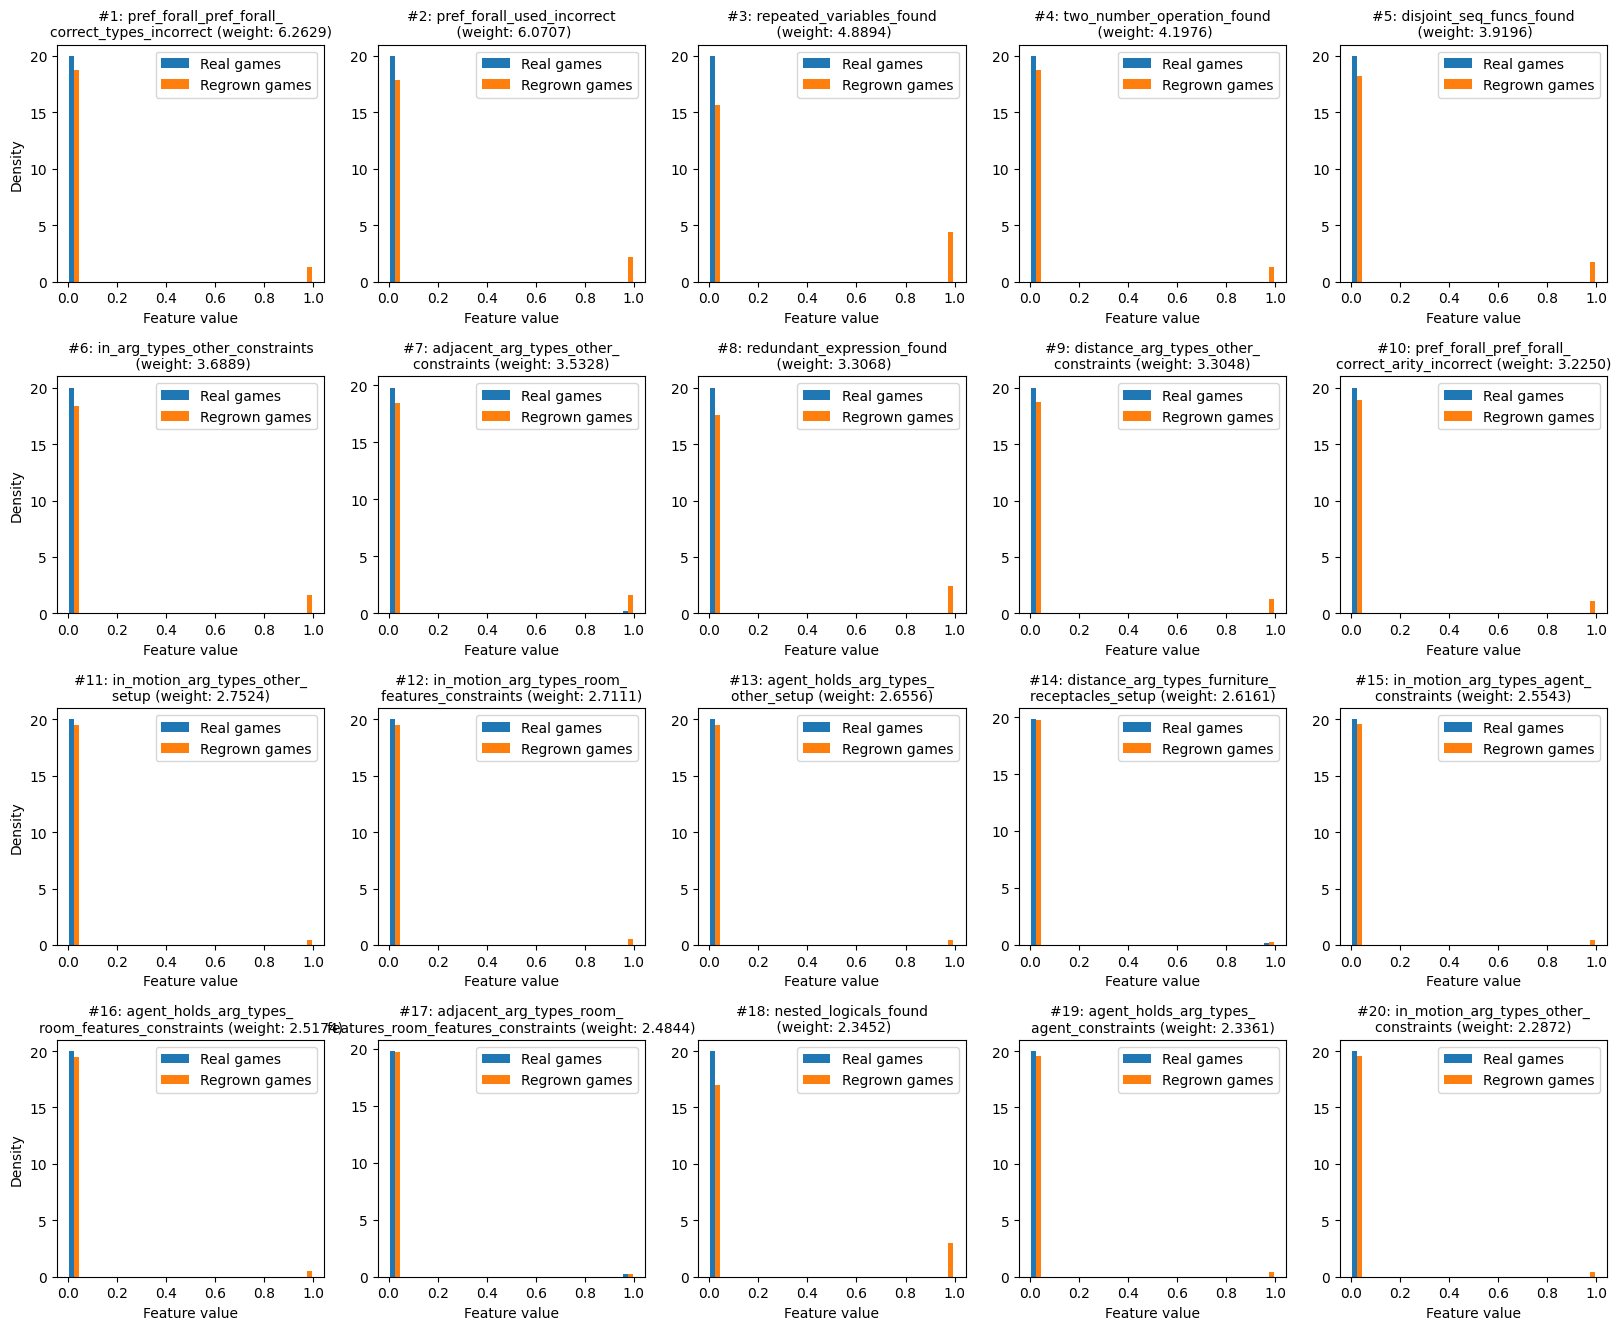

In [20]:
plot_value_histograms(data_df, weights, k=k, largest=True, bins=20,  histogram_log_y=False, histogram_density=True,
    subplots_adjust_params=dict(hspace=0.4), title_fontsize=10)

## Visualizing some top negatives

In [21]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)
if 'wrapper' in cv_energy_model.named_steps: cv_energy_model.named_steps['wrapper'].eval()
full_tensor_scores = cv_energy_model.transform(full_tensor).detach()

In [22]:
real_game_scores = full_tensor_scores[:, 0]
print(f'Real game scores: {real_game_scores.mean():.4f} ± {real_game_scores.std():.4f}, min = {real_game_scores.min():.4f}, max = {real_game_scores.max():.4f}')

Real game scores: -74.5953 ± 0.9756, min = -78.0885, max = -72.8545


In [ ]:
utils.plot_energy_histogram(cv_energy_model, full_tensor)

In [ ]:
negatives_scores = full_tensor_scores[:, 1:]

In [ ]:
positive_scores = full_tensor_scores[:, 0]
score_diffs = negatives_scores - positive_scores.unsqueeze(1)

In [ ]:
torch.topk(score_diffs.ravel(), 10, largest=False)

In [ ]:
N_NEGATIVES = 20
for index in torch.topk(score_diffs.ravel(), N_NEGATIVES, largest=False).indices:
    utils.evaluate_energy_contributions(cv_energy_model, full_tensor, index, 
        feature_columns, full_tensor, real_game_texts, regrown_game_1024_texts, display_features_diff=False, min_display_threshold=0.001)
    
    display(Markdown('---'))

In [ ]:
data_df.loc[data_df.game_name == '5fefd5b2173bfbe890bc98ed-88-1012-nd-4-rd-14-rs-setup-sk-prior1', 'agent_holds_arg_types_other_setup']

In [ ]:
print(regrown_game_1024_texts[75 * 1024 + 1012])

## If we never need to load a featurizer for anything


In [ ]:
from src.fitness_features import *
with gzip.open('../models/fitness_featurizer_2023_03_22.pkl.gz', 'rb') as f:
    featurizer = pickle.load(f)  # type: ignore

In [ ]:
ast = grammar_parser.parse(regrown_game_1024_texts[75 * 1024 + 1012])
r = featurizer.parse(ast, '', True, False)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

In [ ]:
r = featurizer.parse(ast, '', True, True)
{k: v for k, v in r.items() if k.startswith('agent_holds') and k.endswith('setup')}

## Analyzing the role of different variables on the difficulty of the negative

In [ ]:
NEGATIVE_DIFFICULTY_COLUMNS = [
    'game_name', 'regrowth_index', 
    'original_game_name', 'original_game_index', 
    'node_depth', 'regrowth_depth', 
    'regrowth_section', 'regrowth_sampler', 
    'score_diff'
]

def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)


game_name_to_index = {game_name: i for i, game_name in enumerate(data_df.loc[data_df.real == 1, 'game_name'])}


def extract_info_from_game_name(game_name: str):
    i = utils._find_nth(game_name, '-', 2)
    original_game_name, regrowth_info = game_name[:i], game_name[i + 1:]
    regrowth_index, _, node_depth, _, regrowth_depth, _, regrowth_section, _, regrowth_sampler = regrowth_info.split('-')
    regrowth_index = int(regrowth_index)
    node_depth = int(node_depth)
    regrowth_depth = int(regrowth_depth)
    original_game_index = game_name_to_index[original_game_name]
    score_diff = score_diffs[original_game_index, regrowth_index].item()
    return [regrowth_index, original_game_name, original_game_index, node_depth, regrowth_depth, regrowth_section, regrowth_sampler, score_diff]


negative_difficulty_df = data_df.loc[data_df.real == 0, ['game_name']]
negative_difficulty_df = apply_and_concat(negative_difficulty_df, 'game_name', extract_info_from_game_name, NEGATIVE_DIFFICULTY_COLUMNS[1:])




In [ ]:
negative_difficulty_df.head()

In [ ]:
negative_difficulty_df.groupby('regrowth_sampler').score_diff.describe()

In [ ]:
negative_difficulty_df.groupby('regrowth_section').score_diff.describe()

In [ ]:
def sem(x):
    return np.std(x) / np.sqrt(len(x))

regrowth_depth_impact = negative_difficulty_df.groupby('regrowth_depth').score_diff.agg(['mean', sem])

In [ ]:

plt.plot(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, 'o', linestyle='-')
plt.errorbar(regrowth_depth_impact.index.values, regrowth_depth_impact['mean'].values, regrowth_depth_impact['sem'].values, linestyle='None')
plt.xlabel('Regrown tree depth')
plt.ylabel('Mean energy difference (lower is harder)')
plt.title('Mean energy difference by regrown tree depth')
# regrowth_depth_impact['mean']

## Playing around with knocking out weights below some threshold

In [ ]:
full_tensor = utils.df_to_tensor(data_df, feature_columns)


for threshold in (0, 0.1, 0.2, 0.3):
    weights = cv_energy_model.named_steps['fitness'].model.fc1.weight.data.detach().squeeze()  # type: ignore
    weights[weights.abs() < threshold] = 0
    model_copy = copy.deepcopy(cv_energy_model)
    model_copy.named_steps['fitness'].model.fc1.weight.data = weights.unsqueeze(0)  # type: ignore

    print(f'With threshold = {threshold}:')
    print(utils.evaluate_trained_model(model_copy, full_tensor, utils.default_multiple_scoring)) 
    print()